# Definição do Problema

Prever o turnover (rotatividade) de empregados com base em várias características, como demografia, profissão, características psicológicas e outros atributos relacionados ao trabalho.

In [1]:
import pandas as pd
import numpy as np

turnover_data = pd.read_csv('turnover.csv')

# Visão Geral dos Dados

Ao visualizar os dados vemos que existem 16 atributos, dos quais "EVENT" sera o atributo target da nossa predição.

**stag**: Tempo t quando ocorreu o turnover ou tempo de censura do estudo.
**event**: Indica se o evento ocorreu no tempo t.  
**gender**: Gênero do funcionário.  
**age**: Idade do funcionário.  
**industry**: Indústria de atuação do funcionário.  
**profession**: Profissão do funcionário.  
**traffic**: De qual canal o funcionário ingressou para a empresa  
**coach**: Presença de um coach  
**head_gender**: Gênero do supervisor ao qual o funcionario responde  
**greywage**: se o empregador paga apenas uma pequena quantia de salário acima do salário mínimo (white).  
**way**: Forma que o funcionário se desloca para o escritório.  
**extraversion**: Escala segundo o teste Big5.  
**independ**: Escala segundo o teste Big5.  
**selfcontrol**: Escala segundo o teste Big5.  
**anxiety**: Escala segundo o teste Big5.  
**novator**: Escala segundo o teste Big5.  

In [2]:
turnover_data

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1125,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1126,118.800821,0,f,34.0,Telecom,Accounting,KA,no,f,white,bus,4.6,5.5,7.2,6.3,3.7
1127,49.412731,0,f,51.0,Consult,HR,empjs,no,m,grey,bus,3.8,7.6,5.7,6.3,5.2


# Pré-processamento de Dados

## Tratamento de Nulos

In [3]:
pd.DataFrame({
    'Null Count': turnover_data.isnull().sum().fillna(0).astype(int),
    'Dtype': turnover_data.dtypes
})

,Null Count,Dtype
stag,0,float64
event,0,int64
gender,0,object
age,0,float64
industry,0,object
profession,0,object
traffic,0,object
coach,0,object
head_gender,0,object
greywage,0,object


Em uma primeira análise vemos que nao existem valores nulos na nossa base, assim como os tipos de valores existentes são:

quantitativo continuo = 7  
qualitativo nominal = 8

Tambem vemos que na base nao existem valores nulos ou faltando

## Valores repetidos

In [4]:
duplicated_rows = turnover_data[turnover_data.duplicated()]
print(f"Numero de linhas duplicadas = {duplicated_rows.shape[0]}")

Numero de linhas duplicadas = 13


In [5]:
turnover_data = turnover_data.drop_duplicates()

## Outliers

Para determinar os outliers é necessário fazer um estudo sobre os quartis e ver como estes se comportam, porque assim é possivel saber se existe uma tendencia a possuir mais valores de um tipo do que outro e assim analisar os outliers

In [6]:
turnover_data.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000
mean,36.701802,0.501792,31.024734,5.589606,5.474462,5.607527,5.666667,5.877330
std,34.173048,0.500221,6.973078,1.857401,1.702149,1.985720,1.711035,1.903534
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.720739,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.443532,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.622177,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Devido à natureza de que outliers so irão existir em categorias numéricas, diversas colunas podem ser ignoradas. Além disso, com exceção de stag, todas as colunas apresentam uma distribuição igualitária onde o valor do quartil se encaixa de maneira consideravelmente próxima à porcentagem do valor máximo em relação ao mínimo. Portanto a coluna stag é a unica a qual deve ser analisado a existência de outliers.

Nesta situação uma boa técnica é o uso do z-score, o qual mede o desvio padrão de uma instância em relação à media, assim podemos captar outliers.

In [7]:
# Cálculo dos z-scores para todas as colunas numéricas do DataFrame
z_scores = (turnover_data['stag'] - turnover_data['stag'].mean()) / turnover_data['stag'].std()

# Recuperando as linhas que possuem outliers baseado no z-score 3
outliers = z_scores[(z_scores > 3) | (z_scores < -3)].index

len(outliers)

21

In [8]:
turnover_data = turnover_data.drop(outliers)
turnover_data.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,34.447804,0.503196,31.103747,5.600913,5.481187,5.606393,5.650228,5.876256
std,30.295030,0.500218,6.975175,1.860481,1.698809,1.983804,1.715308,1.911019
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.548255,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.016427,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,50.135524,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,139.071869,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


O outlier 2.5 se mostrou adequado pois foi o que mais aproximou o valor discrepante do padrão de quartis

## Balanceamento

Para saber se uma base de dados é balanceada deve-se olhar a destribuição entre o atributo target, que neste caso é a coluna **event**

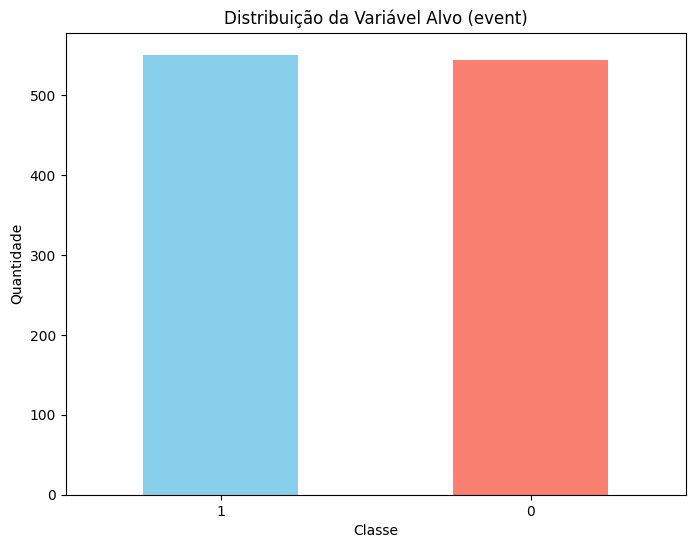

event
1    551
0    544
Name: count, dtype: int64

In [9]:
import matplotlib.pyplot as plt

# Análise da distribuição da variável alvo
event_distribution = turnover_data['event'].value_counts()

# Plotando a distribuição
plt.figure(figsize=(8, 6))
event_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição da Variável Alvo (event)')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

event_distribution

Dado que a base nao é desbalanceada, basta seguir em frente

# Transformação de Dados

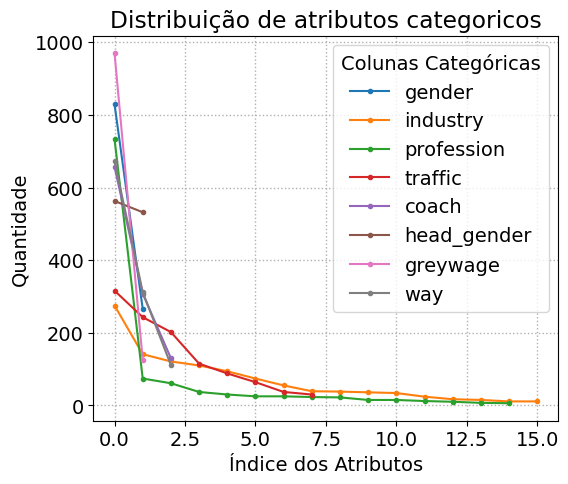

In [10]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

# Seleciona apenas colunas não numéricas
non_numeric_columns = turnover_data.select_dtypes(exclude=['float64', 'int64'])

plt.figure(figsize=(6, 5))

# Para cada coluna categórica
for col in non_numeric_columns.columns:
    values = turnover_data[col].value_counts().tolist()
    plt.plot(range(len(values)), values, marker='.', label=col)

plt.xlabel('Índice dos Atributos')
plt.ylabel('Quantidade')
plt.title('Distribuição de atributos categoricos')
plt.legend(title='Colunas Categóricas', loc='upper right')
plt.grid(True, which='both', linestyle=':', linewidth=1)
plt.show()

Analisando a quantidade de possíveis instâncias por coluna chega-se a conclusão de que existem:  
3 colunas binarizáveis (gender, head_gender e greywage)  
2 colunas pequenas o suficiente para realizar encode ou one hot (coach e way)  
3 colunas que precisarão de um estudo de caso para decidir como tratá-las  

## Industry

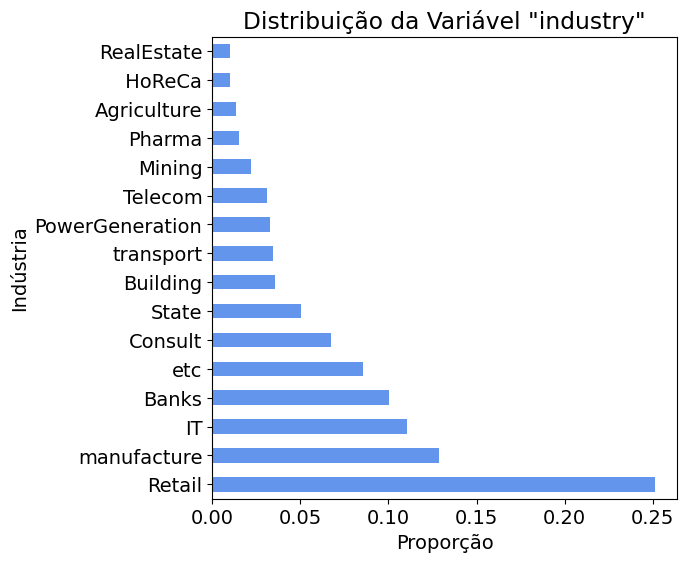

In [11]:
# Análise da variável 'industry'
industry_distribution = turnover_data['industry'].value_counts(normalize=True)

# Plotando a distribuição
plt.figure(figsize=(6, 6))
industry_distribution.plot(kind='barh', color='cornflowerblue')
plt.title('Distribuição da Variável "industry"')
plt.xlabel('Proporção')
plt.ylabel('Indústria')
plt.show()

Industry possui diversos valores com uma destribuição considerável em cada feature.  
Por isso, a estratégia adotada será realizar um encoding onde o valor de industry será substituído pela porcentagem de quantos desses resultados terminaram em turnover, assim ainda permitindo que o modelo retire insights valiosos da feature.

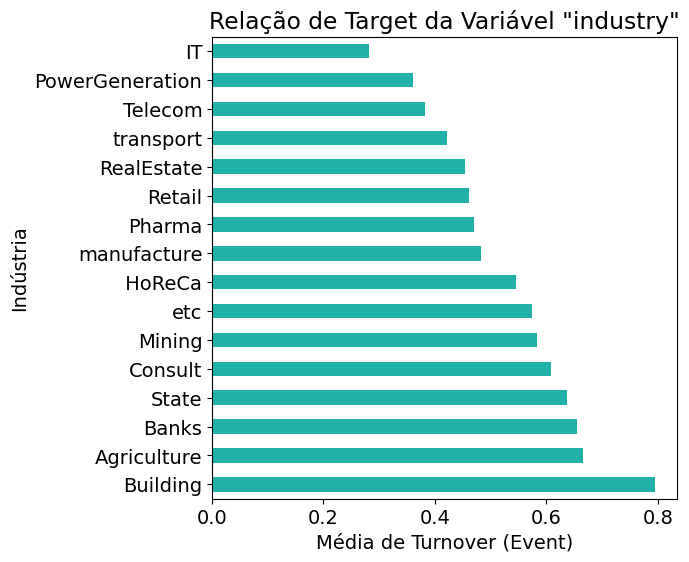

In [12]:
# Calculando a relação de target (mean encoding) para a variável 'industry'
industry_target_relation = turnover_data.groupby('industry')['event'].mean()

# Ordenando os valores para melhor visualização
industry_target_relation_sorted = industry_target_relation.sort_values(ascending=False)

# Plotando a relação de target da variável 'industry'
plt.figure(figsize=(6, 6))
industry_target_relation_sorted.plot(kind='barh', color='lightseagreen')
plt.title('Relação de Target da Variável "industry"')
plt.xlabel('Média de Turnover (Event)')
plt.ylabel('Indústria')
plt.show()

Dado uma relação satisfatória que separa os atributos, o tornam válido para a utilização da técnica, portanto pode-se substituir na tabela original o novo valor

In [13]:
# Aplicando a codificação target (mean encoding) para a variável 'industry' no dataset original
turnover_data['industry_encoded'] = turnover_data['industry'].map(industry_target_relation)

# Substituindo a coluna 'industry' pela coluna 'industry_encoded'
turnover_data.drop('industry', axis=1, inplace=True)
turnover_data.rename(columns={'industry_encoded': 'industry'}, inplace=True)

# Exibindo as primeiras linhas do dataframe após a substituição
turnover_data.head()

,stag,event,gender,age,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator,industry
0,7.030801,1,m,35.0,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3,0.654545
1,22.965092,1,m,33.0,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3,0.654545
2,15.934292,1,f,35.0,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3,0.361111
3,15.934292,1,f,35.0,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7,0.361111
4,8.410678,1,m,32.0,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7,0.461818


## Profession

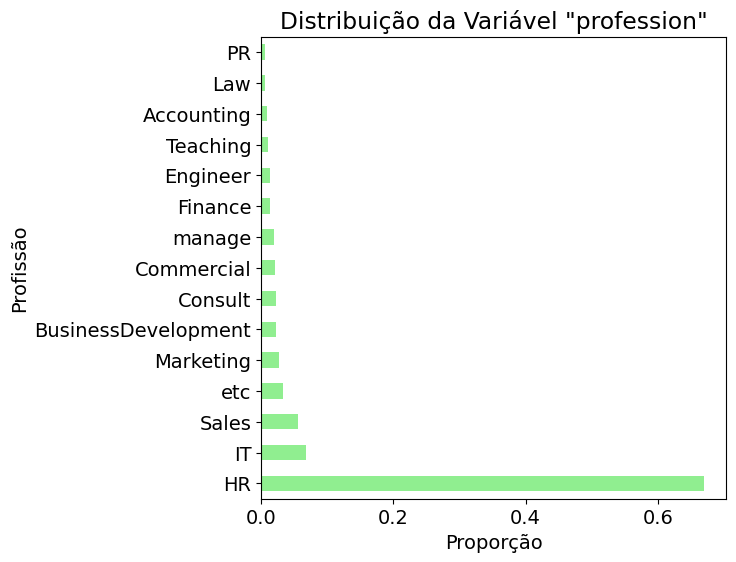

In [14]:
# Análise da variável 'profession'
profession_distribution = turnover_data['profession'].value_counts(normalize=True)

# Plotando a distribuição
plt.figure(figsize=(6, 6))
profession_distribution.plot(kind='barh', color='lightgreen')
plt.title('Distribuição da Variável "profession"')
plt.xlabel('Proporção')
plt.ylabel('Profissão')
plt.show()

Diferente de Industry, Profession possui uma grande quantidade de instâncias aglomeradas em uma única classe de maneira desbalanceada, portanto os valores de classes como PR não irão apresentar um resultado relevante para o nosso modelo. Para tratar isso as classes com uma quantidade de instâncias menor que "Etc" são colocadas dentro desta mesma classe

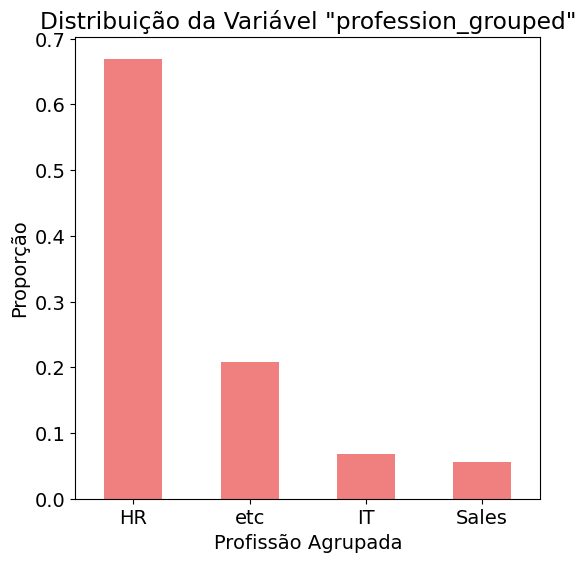

In [15]:
# Calculando a distribuição das categorias em 'profession'
profession_distribution_original = turnover_data['profession'].value_counts(normalize=True)

# Identificando as categorias que serão agrupadas em "etc"
threshold_original = profession_distribution_original['etc']
categories_to_group_original = profession_distribution_original[profession_distribution_original <= threshold_original].index

# Agrupando categorias menos frequentes em "etc"
turnover_data['profession_grouped'] = turnover_data['profession'].apply(lambda x: 'etc' if x in categories_to_group_original else x)

# Verificando a distribuição após o agrupamento
updated_profession_distribution = turnover_data['profession_grouped'].value_counts(normalize=True)

# Plotando a distribuição da variável 'profession_grouped'
plt.figure(figsize=(6, 6))
updated_profession_distribution.plot(kind='bar', color='lightcoral')
plt.title('Distribuição da Variável "profession_grouped"')
plt.xlabel('Profissão Agrupada')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.show()

Estando as instâncias categorizadas em uma pequena quantidade de classes, é possível utilizar One Hot Encoding para classificar o atributo

In [16]:
# Realizando one-hot encoding para 'profession_grouped'
profession_onehot = pd.get_dummies(turnover_data['profession_grouped'], prefix='profession', drop_first=False)

# Concatenando o one-hot encoding ao dataframe original
turnover_data = pd.concat([turnover_data, profession_onehot], axis=1)

# Removendo as colunas 'profession' e 'profession_grouped' já que não são mais necessárias
turnover_data.drop(['profession', 'profession_grouped'], axis=1, inplace=True)

# Exibindo as primeiras linhas do dataframe atualizado
turnover_data.head()

,stag,event,gender,age,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator,industry,profession_HR,profession_IT,profession_Sales,profession_etc
0,7.030801,1,m,35.0,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3,0.654545,True,False,False,False
1,22.965092,1,m,33.0,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3,0.654545,True,False,False,False
2,15.934292,1,f,35.0,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3,0.361111,True,False,False,False
3,15.934292,1,f,35.0,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7,0.361111,True,False,False,False
4,8.410678,1,m,32.0,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7,0.461818,False,False,False,True


## Traffic

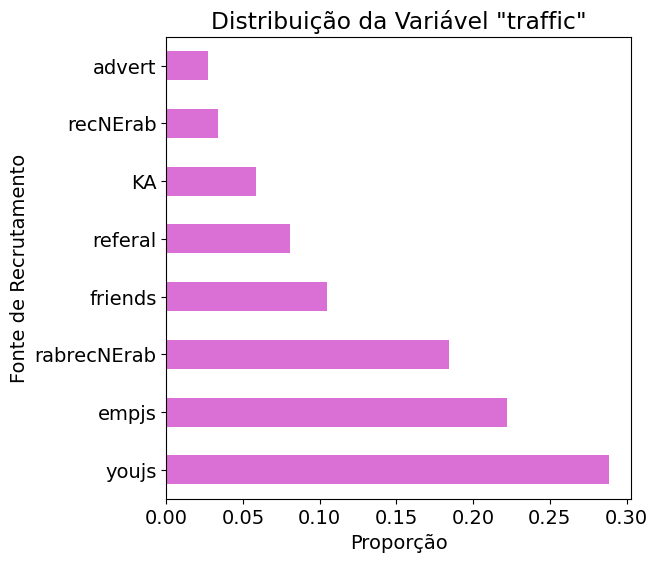

In [17]:
# Análise da variável 'traffic'
traffic_distribution = turnover_data['traffic'].value_counts(normalize=True)

# Plotando a distribuição
plt.figure(figsize=(6, 6))
traffic_distribution.plot(kind='barh', color='orchid')
plt.title('Distribuição da Variável "traffic"')
plt.xlabel('Proporção')
plt.ylabel('Fonte de Recrutamento')
plt.show()

Traffic acaba tendo o mesmo problema de Industry por não ter um desbalanceamento demasiadamente grande, por isso é sugerido seguir pelo mesmo caminho de realizar um mean encoding

In [18]:
# Calculando mean encoding para a variável 'traffic'
traffic_mean_encoding = turnover_data.groupby('traffic')['event'].mean()

# Aplicando a codificação para visualização
turnover_data['traffic_encoded'] = turnover_data['traffic'].map(traffic_mean_encoding)

# Exibindo as primeiras linhas da coluna original 'traffic' e da coluna codificada 'traffic_encoded'
traffic_comparison = turnover_data[['traffic', 'traffic_encoded']].drop_duplicates().sort_values(by='traffic_encoded', ascending=False)

# Substituindo a coluna 'traffic' pela coluna 'traffic_encoded'
turnover_data.drop('traffic', axis=1, inplace=True)
turnover_data.rename(columns={'traffic_encoded': 'traffic'}, inplace=True)

# Exibindo as primeiras linhas do dataframe após a substituição
turnover_data.head()

,stag,event,gender,age,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator,industry,profession_HR,profession_IT,profession_Sales,profession_etc,traffic
0,7.030801,1,m,35.0,no,f,white,bus,6.2,4.1,5.7,7.1,8.3,0.654545,True,False,False,False,0.608911
1,22.965092,1,m,33.0,no,m,white,bus,6.2,4.1,5.7,7.1,8.3,0.654545,True,False,False,False,0.522634
2,15.934292,1,f,35.0,no,m,white,bus,6.2,6.2,2.6,4.8,8.3,0.361111,True,False,False,False,0.608911
3,15.934292,1,f,35.0,no,m,white,bus,5.4,7.6,4.9,2.5,6.7,0.361111,True,False,False,False,0.608911
4,8.410678,1,m,32.0,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7,0.461818,False,False,False,True,0.439873


## Coach

Coach pode ser considerado um atributo binário a partir de certo ponto de vista, mas para a pesquisa foi diferenciado entre o coach ser um agente externo ou o próprio treinador do funcionàrio, para isso é seguro afirmar que podemos realizar um encoding contando que "my head" seja colocado ao lado de "yes" como um supertipo, mas não importando a ordem entre os dois

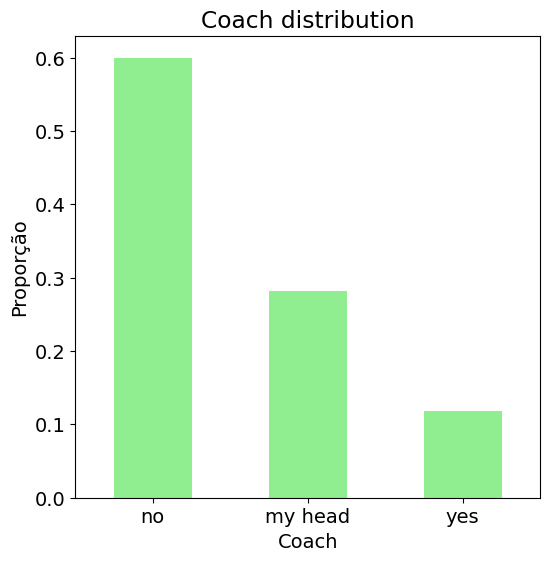

coach
no         0.600000
my head    0.281279
yes        0.118721
Name: proportion, dtype: float64

In [19]:
# Calculando a distribuição dos valores na coluna 'coach'
coach_distribution = turnover_data['coach'].value_counts(normalize=True)

# Plotando a distribuição dos valores
plt.figure(figsize=(6, 6))
coach_distribution.plot(kind='bar', color='lightgreen')
plt.title('Coach distribution')
plt.xlabel('Coach')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.show()

coach_distribution

In [20]:
# Criando a coluna 'coach_encoded'
turnover_data['coach_encoded'] = turnover_data['coach'].map({'yes': 2, 'no': 0, 'my head': 1})

# Removendo a coluna original 'coach'
turnover_data.drop('coach', axis=1, inplace=True)

## Way

Os valores de way não são possíveis de se relacionar diretamente por não possuirem uma cardinalidade, portanto deve-se usar uma estratégia de separá-los em atributos binarizados, já que possuem apenas 3 tipos de instâncias

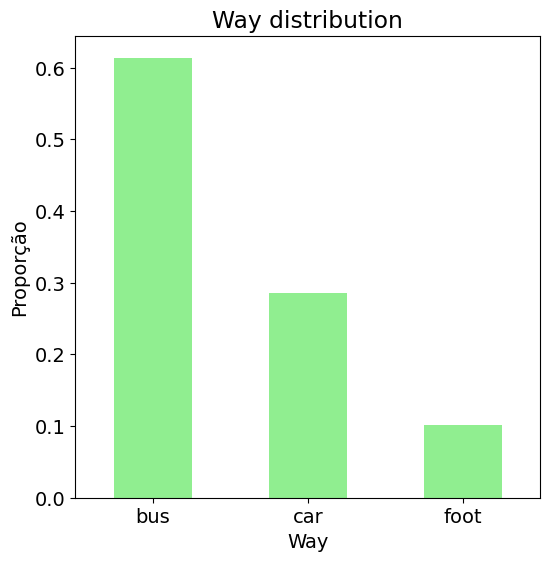

way
bus     0.613699
car     0.284932
foot    0.101370
Name: proportion, dtype: float64

In [21]:
# Calculando a distribuição dos valores na coluna 'way'
coach_distribution = turnover_data['way'].value_counts(normalize=True)

# Plotando a distribuição dos valores
plt.figure(figsize=(6, 6))
coach_distribution.plot(kind='bar', color='lightgreen')
plt.title('Way distribution')
plt.xlabel('Way')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.show()

coach_distribution

In [22]:
# Realizando one-hot encoding para a variável 'way'
way_onehot = pd.get_dummies(turnover_data['way'], prefix='way', drop_first=False)

# Concatenando o one-hot encoding ao dataframe original
turnover_data = pd.concat([turnover_data, way_onehot], axis=1)

# Removendo a coluna original 'way' já que não é mais necessária
turnover_data.drop('way', axis=1, inplace=True)

# Exibindo as primeiras linhas do dataframe após o one-hot encoding
turnover_data.head()

,stag,event,gender,age,head_gender,greywage,extraversion,independ,selfcontrol,anxiety,...,industry,profession_HR,profession_IT,profession_Sales,profession_etc,traffic,coach_encoded,way_bus,way_car,way_foot
0,7.030801,1,m,35.0,f,white,6.2,4.1,5.7,7.1,...,0.654545,True,False,False,False,0.608911,0,True,False,False
1,22.965092,1,m,33.0,m,white,6.2,4.1,5.7,7.1,...,0.654545,True,False,False,False,0.522634,0,True,False,False
2,15.934292,1,f,35.0,m,white,6.2,6.2,2.6,4.8,...,0.361111,True,False,False,False,0.608911,0,True,False,False
3,15.934292,1,f,35.0,m,white,5.4,7.6,4.9,2.5,...,0.361111,True,False,False,False,0.608911,0,True,False,False
4,8.410678,1,m,32.0,f,white,3.0,4.1,8.0,7.1,...,0.461818,False,False,False,True,0.439873,2,True,False,False


## Binarização de atributos com 2 categorias

In [23]:
# Identificando colunas com exatamente 2 valores únicos
binary_columns = [col for col in turnover_data.columns if turnover_data[col].nunique() == 2]

# Binarizando as colunas identificadas
for col in binary_columns:
    unique_vals = turnover_data[col].unique()
    turnover_data[col] = turnover_data[col].replace({unique_vals[0]: 0, unique_vals[1]: 1})

# Exibindo as primeiras linhas do dataframe após a binarização
turnover_data.head()

,stag,event,gender,age,head_gender,greywage,extraversion,independ,selfcontrol,anxiety,...,industry,profession_HR,profession_IT,profession_Sales,profession_etc,traffic,coach_encoded,way_bus,way_car,way_foot
0,7.030801,0,0,35.0,0,0,6.2,4.1,5.7,7.1,...,0.654545,0,0,0,0,0.608911,0,0,0,0
1,22.965092,0,0,33.0,1,0,6.2,4.1,5.7,7.1,...,0.654545,0,0,0,0,0.522634,0,0,0,0
2,15.934292,0,1,35.0,1,0,6.2,6.2,2.6,4.8,...,0.361111,0,0,0,0,0.608911,0,0,0,0
3,15.934292,0,1,35.0,1,0,5.4,7.6,4.9,2.5,...,0.361111,0,0,0,0,0.608911,0,0,0,0
4,8.410678,0,0,32.0,0,0,3.0,4.1,8.0,7.1,...,0.461818,1,0,0,1,0.439873,2,0,0,0


## Normalização \ Padronização

In [24]:
# Exibindo as primeiras linhas do dataframe após a normalização
turnover_data.describe().loc[['min', 'max']]

,stag,event,gender,age,head_gender,greywage,extraversion,independ,selfcontrol,anxiety,...,industry,profession_HR,profession_IT,profession_Sales,profession_etc,traffic,coach_encoded,way_bus,way_car,way_foot
min,0.394251,0.0,0.0,18.0,0.0,0.0,1.0,1.0,1.0,1.7,...,0.280992,0.0,0.0,0.0,0.0,0.339130,0.0,0.0,0.0,0.0
max,139.071869,1.0,1.0,58.0,1.0,1.0,10.0,10.0,10.0,10.0,...,0.794872,1.0,1.0,1.0,1.0,0.693182,2.0,1.0,1.0,1.0


Devido aos valores estarem contidos dentro de um range relativamente curto, não se torna obrigatório realizar a normalização, mas ainda assim se torna benéfico para a qualidade do nosso modelo para evitar peso desnecessário em stag

In [25]:
# Identificando colunas que precisam ser normalizadas
columns_to_normalize = [col for col in turnover_data.columns 
                        if turnover_data[col].min() < 0 or turnover_data[col].max() > 1]

# Normalizando as colunas identificadas
for col in columns_to_normalize:
    turnover_data[col] = (turnover_data[col] - turnover_data[col].min()) / \
                                 (turnover_data[col].max() - turnover_data[col].min())

turnover_data.describe().loc[['min', 'max']]

,stag,event,gender,age,head_gender,greywage,extraversion,independ,selfcontrol,anxiety,...,industry,profession_HR,profession_IT,profession_Sales,profession_etc,traffic,coach_encoded,way_bus,way_car,way_foot
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.280992,0.0,0.0,0.0,0.0,0.339130,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.794872,1.0,1.0,1.0,1.0,0.693182,1.0,1.0,1.0,1.0


# Análise Exploratória de Dados

Atraves da analise de correlação entre os elementos podemos ver se o crescimento das variaveis segue direta ou inversamente o crescimento de determinada variavel alvo, seguindo uma escala que começa de 1 se for diretamente proporcional ou até -1 se for inversamente proporcional.
Nem sempre estas relações significam que no treinamento do modelo elas não possuirão relevancia, mas ainda sim é um grande indicativo e muitos insights podem ser retirados delas.

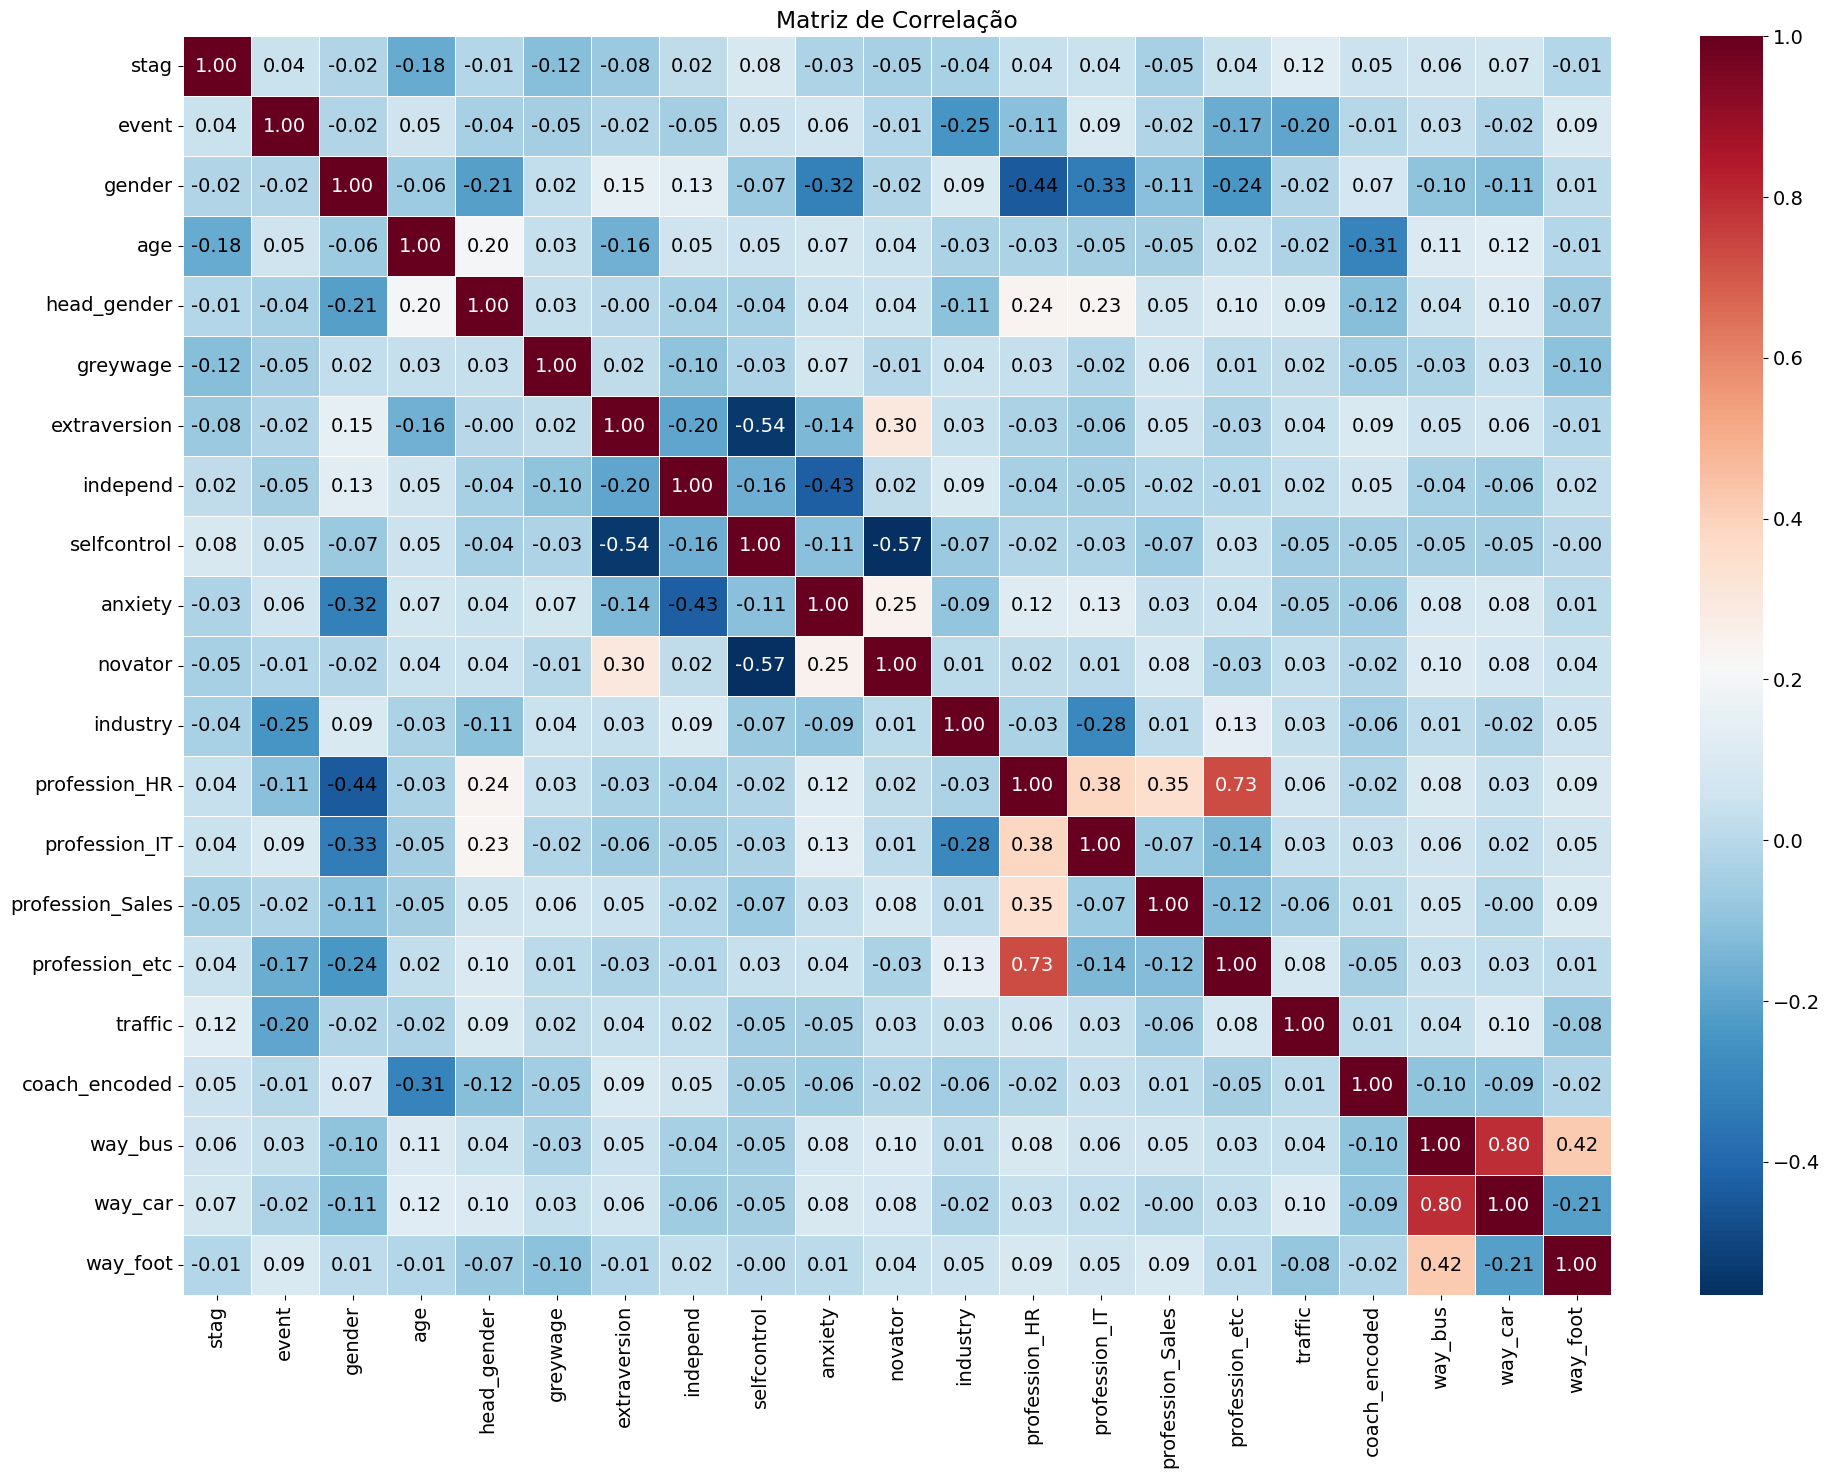

In [26]:
import seaborn as sns

# Calculando a matriz de correlação
correlation_matrix = turnover_data.corr()

# Plotando a matriz de correlação usando um heatmap
plt.figure(figsize=(20, 15))
ax = sns.heatmap(correlation_matrix, cmap='RdBu_r', fmt='.2f', linewidths=0.5)

# Adicionar anotações numéricas manualmente
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        value = correlation_matrix.iloc[i, j]
        # Ajustando a cor baseada no valor da correlação
        text_color = 'black' if -0.5 < value < 0.5 else 'white'
        ax.text(j + 0.5, i + 0.5, f'{value:.2f}', ha='center', va='center', color=text_color, fontsize=14)

plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

E possível identificar que existe correlação consideravelmente alta entre os valores de way_car para way_bus assim como de professional_etc para professional_HR

mas para o caso de way_car, a relação entre este valor para way_foot fornece um insight importante para perceber que por mesmo que exista uma correlação próxima, ele ainda é um forte candidato a realizar desempates em relação a terceiras e quartas variáveis.

Ambos os dois casos naturalmente possuem uma correlação devido ao fato de serem mutuamente excludentes durante seu processo de encoding, mas ainda assim seus valores interferem na avaliação final do modelo

#### Agora correlacionando exclusivamente os valores em relação ao evento em questão temos os seguintes:

In [42]:
turnover_data.corr()['event'].sort_values(ascending=False).drop('event')

way_foot            0.089897
anxiety             0.060485
age                 0.053539
selfcontrol         0.047828
stag                0.044558
way_bus             0.033207
extraversion       -0.016989
profession_Sales   -0.018356
way_car            -0.024290
head_gender        -0.042759
greywage           -0.046527
independ           -0.051918
profession_HR      -0.108105
profession_etc     -0.170202
traffic            -0.196490
industry           -0.247072
Name: event, dtype: float64

Levando isso em conta e testes que foram realizados no modelo final, concluimos que gender, profession_IT, novator e coach_encoded diminuem o score geral dos modelos. Isso juntamente com sua pontuação proxima de 0 na analise de correlação nos faz decidir tira-los da tabela.

In [28]:
# Removendo as variáveis relacionadas a 'profession', 'way' e 'greywage'
columns_to_drop = ['gender'] + ['profession_IT'] + ['novator'] + ['coach_encoded']
turnover_data = turnover_data.drop(columns=columns_to_drop)

# Verificando as primeiras linhas do dataframe após a remoção das variáveis
turnover_data.head()

,stag,event,age,head_gender,greywage,extraversion,independ,selfcontrol,anxiety,industry,profession_HR,profession_Sales,profession_etc,traffic,way_bus,way_car,way_foot
0,0.047856,0,0.425,0,0,0.577778,0.344444,0.522222,0.650602,0.654545,0,0,0,0.608911,0,0,0
1,0.162758,0,0.375,1,0,0.577778,0.344444,0.522222,0.650602,0.654545,0,0,0,0.522634,0,0,0
2,0.112059,0,0.425,1,0,0.577778,0.577778,0.177778,0.373494,0.361111,0,0,0,0.608911,0,0,0
3,0.112059,0,0.425,1,0,0.488889,0.733333,0.433333,0.096386,0.361111,0,0,0,0.608911,0,0,0
4,0.057806,0,0.350,0,0,0.222222,0.344444,0.777778,0.650602,0.461818,1,0,1,0.439873,0,0,0


# Divisão dos Dados

Devido a pequena quantidade de dados da base se torna necessário separar uma maior quantidade de valores de treinamento paara os modelos

In [29]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em conjuntos de treinamento e validação de forma aleatória
train_data_simple, validation_data_simple = train_test_split(turnover_data, test_size=0.15, random_state=66)

# Verificando o tamanho dos conjuntos
len(train_data_simple), len(validation_data_simple)

(930, 165)

In [30]:
# Definindo as características e a variável alvo
X_train = train_data_simple.drop('event', axis=1)
y_train = train_data_simple['event']
X_val = validation_data_simple.drop('event', axis=1)
y_val = validation_data_simple['event']

# Criação dos Modelos

Varios modelos serão usados para treinamento para que sejamos capazes de chegar a uma boa conclusão sobre a resolução proposta para o problemas. Para isso é importante definir funções para facilitar a parte comum entre os modelos

In [31]:
# Avaliacao de modelos
from sklearn.metrics import classification_report

# Definicao de algumas funcoes uteis para a chamada dos modelos

def compute_report(y_pred):
    report = classification_report(y_val, y_pred, output_dict=True, target_names=['No', 'Yes'])
    report = pd.DataFrame(report).transpose().round(2)
    report = report.drop(['macro avg', 'weighted avg'])
    report = report.drop(['support'], axis=1)
    accuracy_val = report.loc['accuracy', 'precision']
    report = report.drop('accuracy')
    report.loc['accuracy'] = [accuracy_val, "", ""]

    return report

def predict(model, converto_to_np = False):
    if converto_to_np:
        model.fit(np.ascontiguousarray(X_train), np.ascontiguousarray(y_train))
        return model.predict(np.ascontiguousarray(X_val))
    else:
        model.fit(X_train, y_train)
        return model.predict(X_val)


# Treinamento dos modelos

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from keras import layers

# Criando os modelos
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = GaussianNB()
gb = GradientBoostingClassifier()
lr = LogisticRegression()
ab = AdaBoostClassifier()
kn = KNeighborsClassifier()

nn = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
_ = nn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    verbose=0
)

## Definição de hiperparâmetros para o uso de RandomizedSearch

In [33]:
# Decision Tree
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

# Random Forest
param_dist_rf = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Naive Bayes
param_dist_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Gradient Boosting
param_dist_gb = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.001, 0.1, 1],
    'n_estimators': [50, 100, 200, 500],
    'criterion': ['friedman_mse', 'squared_error']
}

# Regressão Logistica
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
param_dist_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [50, 100, 500, 1000, 5000],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    
}

# AdaBoost
param_dist_ab = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

# KNeighbors
param_dist_kn = {
    'n_neighbors': [3, 5, 8],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 50],
    'p': [1, 2]
}

## Treinamento dos modelos utilizando o Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Definindo a instancia de Grid Search
grid_search_dt = GridSearchCV(dt, param_grid=param_dist_dt, cv=3, n_jobs=1, verbose = 1, error_score='raise')
grid_search_rf = GridSearchCV(rf, param_grid=param_dist_rf, cv=3, n_jobs=1, verbose = 1, error_score='raise')
grid_search_nb = GridSearchCV(nb, param_grid=param_dist_nb, cv=3, n_jobs=1, verbose = 1, error_score='raise')
grid_search_gb = GridSearchCV(gb, param_grid=param_dist_gb, cv=3, n_jobs=1, verbose = 1, error_score='raise')
grid_search_lr = GridSearchCV(lr, param_grid=param_dist_lr, cv=3, n_jobs=1, verbose = 1, error_score='raise')
grid_search_ab = GridSearchCV(ab, param_grid=param_dist_ab, cv=3, n_jobs=1, verbose = 1, error_score='raise')
grid_search_kn = GridSearchCV(kn, param_grid=param_dist_kn, cv=3, n_jobs=1, verbose = 1, error_score='raise')

# Ajustando os valores
print('------------ Decision Tree ------------')
grid_search_dt.fit(X_train, y_train)
print('------------ Random Forest ------------')
grid_search_rf.fit(X_train, y_train)
print('------------- Naive Bayes -------------')
grid_search_nb.fit(X_train, y_train)
print('---------- Gradient Boosting ----------')
grid_search_gb.fit(X_train, y_train)
print('--------- Regressão Logistica ---------')
grid_search_lr.fit(X_train, y_train)
print('-------------- Ada Boost --------------')
grid_search_ab.fit(X_train, y_train)
print('------------- K Neighbors -------------')
grid_search_kn.fit(np.ascontiguousarray(X_train), np.ascontiguousarray(y_train))

------------ Decision Tree ------------
Fitting 3 folds for each of 300 candidates, totalling 900 fits
------------ Random Forest ------------
Fitting 3 folds for each of 450 candidates, totalling 1350 fits
------------- Naive Bayes -------------
Fitting 3 folds for each of 5 candidates, totalling 15 fits
---------- Gradient Boosting ----------
Fitting 3 folds for each of 48 candidates, totalling 144 fits
--------- Regressão Logistica ---------
Fitting 3 folds for each of 180 candidates, totalling 540 fits
-------------- Ada Boost --------------
Fitting 3 folds for each of 32 candidates, totalling 96 fits
------------- K Neighbors -------------
Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, error_score='raise', estimator=KNeighborsClassifier(),
             n_jobs=1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 30, 50], 'n_neighbors': [3, 5, 8],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             verbose=1)

In [51]:
print(f'Decision Tree       = {grid_search_dt.best_params_}')
print(f'Random Forest       = {grid_search_rf.best_params_}')
print(f'Naive Bayes         = {grid_search_nb.best_params_}')
print(f'Gradient Boosting   = {grid_search_gb.best_params_}')
print(f'Regressão Logistica = {grid_search_lr.best_params_}')
print(f'Ada Boost           = {grid_search_ab.best_params_}')
print(f'K-Neighbors         = {grid_search_kn.best_params_}')

Decision Tree       = {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Random Forest       = {'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Naive Bayes         = {'var_smoothing': 1e-09}
Gradient Boosting   = {'criterion': 'squared_error', 'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 200}
Regressão Logistica = {'C': 10, 'max_iter': 50, 'solver': 'liblinear'}
Ada Boost           = {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
K-Neighbors         = {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


## Predição de valores com os algoritmos devidamente treinados

In [36]:
# Fazendo previsões
dt_y_pred = grid_search_dt.best_estimator_.predict(X_val)
rf_y_pred = grid_search_rf.best_estimator_.predict(X_val)
nb_y_pred = grid_search_nb.best_estimator_.predict(X_val)
gb_y_pred = grid_search_gb.best_estimator_.predict(X_val)
lr_y_pred = grid_search_lr.best_estimator_.predict(X_val)
ab_y_pred = grid_search_ab.best_estimator_.predict(X_val)
kn_y_pred = grid_search_kn.best_estimator_.predict(np.ascontiguousarray(X_val))

nn_y_pred = (nn.predict(X_val) > 0.5).astype("int32").flatten()

6/6 [==============================] - 0s 928us/step


# Matriz de confusão

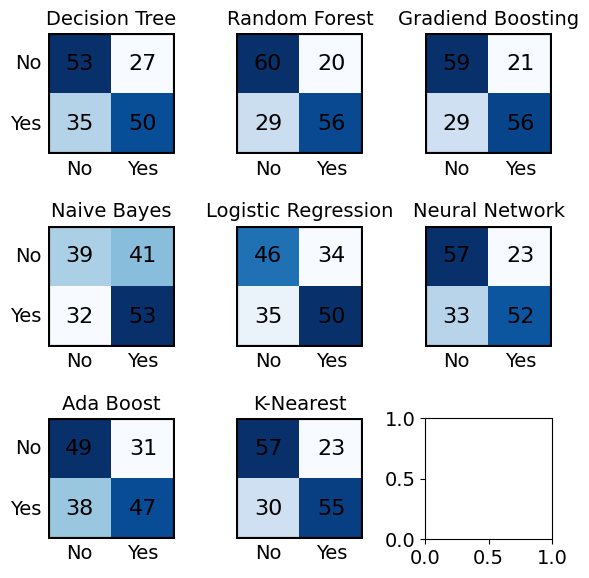

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle

conf_matrix_dt = confusion_matrix(y_val, dt_y_pred)
conf_matrix_rf = confusion_matrix(y_val, rf_y_pred)
conf_matrix_gb = confusion_matrix(y_val, gb_y_pred)
conf_matrix_nb = confusion_matrix(y_val, nb_y_pred)
conf_matrix_lr = confusion_matrix(y_val, lr_y_pred)
conf_matrix_nn = confusion_matrix(y_val, nn_y_pred)
conf_matrix_ab = confusion_matrix(y_val, ab_y_pred)
conf_matrix_kn = confusion_matrix(y_val, kn_y_pred)

matrices = [conf_matrix_dt, conf_matrix_rf, conf_matrix_gb, conf_matrix_nb, conf_matrix_lr, conf_matrix_nn, conf_matrix_ab, conf_matrix_kn]
titles = ['Decision Tree', 'Random Forest', 'Gradiend Boosting', 'Naive Bayes', 'Logistic Regression', 'Neural Network', 'Ada Boost', 'K-Nearest']

# 3 linhas, 3 colunas
fig, axarr = plt.subplots(3, 3, figsize=(6, 6))  

# Para facilitar a iteração, vamos achatá-lo (flatten)
axes = axarr.flatten()

classes = ['No', 'Yes']  # Classes

# Agora iteramos sobre as matrizes e os títulos como antes, mas usando o axes achatado
for i, (matrix, title) in enumerate(zip(matrices, titles)):
    axes[i].imshow(matrix, cmap="Blues", aspect='auto')
    axes[i].set_title(title, fontsize=14)
    
    # Adicionar anotações numéricas com tamanho de fonte maior
    for j in range(matrix.shape[0]):
        for k in range(matrix.shape[1]):
            axes[i].text(k, j, str(matrix[j, k]), ha='center', va='center', fontsize=16)
    
    axes[i].axis('off')
    rect = Rectangle((0,0), 1, 1, edgecolor='black', facecolor='none', transform=axes[i].transAxes, linewidth=3)
    axes[i].add_patch(rect)

    # Rótulos das linhas (classe verdadeira)
    if i == 0 or i == 3 or i == 6:
        for j, cls in enumerate(classes):
            axes[i].text(-0.6, j, cls, ha='right', va='center', color='black', transform=axes[i].transData)
        # Rótulos das colunas (classe prevista)
    for j, cls in enumerate(classes):
        axes[i].text(j, 1.9, cls, ha='center', va='bottom', color='black', transform=axes[i].transData)

plt.tight_layout()
plt.show()

A partir de uma visão geral da matriz de confusão conseguimos perceber que existe uma proporção entre a predição correta de valores sim/nao, mostrando que a precisão irá se aproximar bastante do recall

# Validação do modelo

In [38]:
# Computando a validacao do modelo
dt_report = compute_report(dt_y_pred)
rf_report = compute_report(rf_y_pred)
nb_report = compute_report(nb_y_pred)
gb_report = compute_report(gb_y_pred)
lr_report = compute_report(lr_y_pred)
nn_report = compute_report(nn_y_pred)
ab_report = compute_report(ab_y_pred)
kn_report = compute_report(kn_y_pred)

dt_report['model'] = 'Decision Tree'
rf_report['model'] = 'Random Forest'
gb_report['model'] = 'Gradiend Boosting'
nb_report['model'] = 'Naive Bayes'
lr_report['model'] = 'Logistic Regression'
nn_report['model'] = 'Neural Network'
ab_report['model'] = 'Ada Boost'
kn_report['model'] = 'K-nearest'

reports = [dt_report, rf_report, gb_report, nb_report, lr_report, nn_report, ab_report, kn_report]

def transform_report(report):
    transformed = {
        'Model': report['model'].iloc[0],
        'Accuracy': report.loc['accuracy', 'precision'],
        'Precision(No)': report.loc['No', 'precision'],
        'Recall(No)': report.loc['No', 'recall'],
        'F1-Score(No)': report.loc['No', 'f1-score'],
        'Precision(Yes)': report.loc['Yes', 'precision'],
        'Recall(Yes)': report.loc['Yes', 'recall'],
        'F1-Score(Yes)': report.loc['Yes', 'f1-score'],
    }
    return transformed

summary_data = [transform_report(report) for report in reports]
summary_df = pd.DataFrame(summary_data)

summary_df

,Model,Accuracy,Precision(No),Recall(No),F1-Score(No),Precision(Yes),Recall(Yes),F1-Score(Yes)
0,Decision Tree,0.62,0.60,0.66,0.63,0.65,0.59,0.62
1,Random Forest,0.70,0.67,0.75,0.71,0.74,0.66,0.70
2,Gradiend Boosting,0.70,0.67,0.74,0.70,0.73,0.66,0.69
3,Naive Bayes,0.56,0.55,0.49,0.52,0.56,0.62,0.59
4,Logistic Regression,0.58,0.57,0.57,0.57,0.60,0.59,0.59
5,Neural Network,0.66,0.63,0.71,0.67,0.69,0.61,0.65
6,Ada Boost,0.58,0.56,0.61,0.59,0.60,0.55,0.58
7,K-nearest,0.68,0.66,0.71,0.68,0.71,0.65,0.67


Dentre os modelos propostos o metodo de **Random Forest** foi aquele que teve o maior destaque, chegando a uma acurácia de 72%, uma precisão de 69% e um recall de 75%. Para decidir entre qual é mais importante, seja Precisão ou Recall é importante se analisar o contexto no qual a empresa que está realizando a análise esta. 

Priorizar a **Precisão** esta correlacionado a ideia de diminuir o número de "alarmes falsos", o que é especialmente útil caso a empresa queira realizar ações caras ou significativas para intervir, como o oferecimento de bônus ou promoções para reter talentos.

Priorizar o **Recall** se torna importante caso a empresa queira evitar perder funcionários devido a rotatividade por exemplo. Ter um recall baixo significa que muitos funcionários que realmente saíram não foram identificados pelo modelos, isso se torna crítico em setores ou funções onde a perda de talentos é muito custosa para a organização (por exemplo em casos altamente especializados).

# Interpretabilidade dos modelos gerados

Modelos baseados em árvore podem ser usados para se analisar quais atributos tiveram mais importância no treinamento, a partir de uma análise de quais foram os nós raiz gerados.

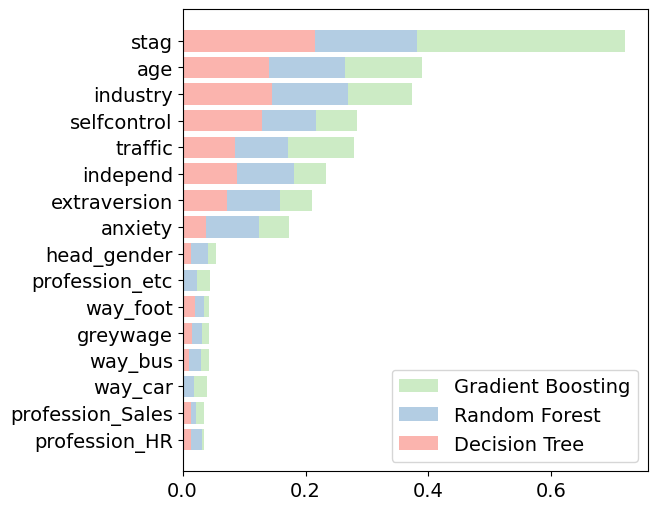

In [39]:
# Para Random Forest, por exemplo:
importances_dt = grid_search_dt.best_estimator_.feature_importances_
importances_rf = grid_search_rf.best_estimator_.feature_importances_
importances_gb = grid_search_gb.best_estimator_.feature_importances_

# Criando o DataFrame
df_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance_dt': importances_dt,
    'importance_rf': importances_rf,
    'importance_gb': importances_gb
})

# Crie uma coluna com o valor acumulado das importâncias
df_importances['total_importance'] = df_importances['importance_dt'] + df_importances['importance_rf'] + df_importances['importance_gb']

# Ordene o DataFrame com base na importância total, em ordem decrescente
df_importances = df_importances.sort_values(by='total_importance', ascending=False)

# Valores acumulados
df_importances['importance_rf_acc'] = df_importances['importance_dt'] + df_importances['importance_rf']
df_importances['importance_gb_acc'] = df_importances['importance_rf_acc'] + df_importances['importance_gb']

# Configurar figura e eixos
plt.figure(figsize=(6, 6))

colors = sns.color_palette("Pastel1", n_colors=3)
# Plotando importância para cada modelo
plt.barh(df_importances['feature'], df_importances['importance_gb_acc'], color=colors[2], label='Gradient Boosting')
plt.barh(df_importances['feature'], df_importances['importance_rf_acc'], color=colors[1], label='Random Forest')
plt.barh(df_importances['feature'], df_importances['importance_dt'], color=colors[0], label='Decision Tree')
plt.gca().invert_yaxis()


plt.legend(loc='lower right')
plt.show()

Com estes dados podemos chegar a algumas conclusões importantes, sendo a principal o tempo de permanência do funcionário o principal fator de influência para saber se ele vai ficar na empresa ou não. Outras inferências podem ser feitas como a importância do tipo de industria sobre o tipo de cargo, o que indica que o clima e cultura empresarial são fortes candidatos para a análise de sobrevivência de funcionários. Por outro lado características pessoais de auto controle e ansiedade se mostraram também importantes, sendo estas provavelmente relacionadas a resiliência do indivíduo. É válido ressaltar que o meio de contratação pode acabar também indicando a existência de fatores culturais vindos daquela plataforma. E por fim que a idade é um fator crucial para saber a resiliência de um funcionário em uma vaga.